Handpoints2angles

Notebook that reads the CSV saved Data from for example Dataset DHG and calculates the handangles out of it

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from handpoints2anglesv2 import *
from pathlib import Path
from scipy.spatial.transform import Slerp, Rotation
import os
import re
from scipy.spatial.transform import Rotation as R
# import chart_studio
# chart_studio.tools.set_credentials_file(username='mado24', api_key='6yxG1nNuc8NtNNktcJ3D')
# import chart_studio.plotly as plotly

In [2]:
# Namesof the joints that, CSV file does not contain these, named acordingly to the manus gloves

joint_names = {
    0: 'Wrist',
    1: 'Palm',
    2: 'Thumb_CMC',
    3: 'Thumb_MCP',
    4: 'Thumb_IP',
    5: 'Thumb_TIP',
    6: 'Index_MCP',
    7: 'Index_PIP',
    8: 'Index_DIP',
    9: 'Index_TIP',
    10: 'Middle_MCP',
    11: 'Middle_PIP',
    12: 'Middle_DIP',
    13: 'Middle_TIP',
    14: 'Ring_MCP',
    15: 'Ring_PIP',
    16: 'Ring_DIP',
    17: 'Ring_TIP',
    18: 'Pinky_MCP',
    19: 'Pinky_PIP',
    20: 'Pinky_DIP',
    21: 'Pinky_TIP'
}

In [3]:
'''calculates the angles out of the given skeletal data and stores it in an pickle file. Additionally for the stored angle slinear interpolation is done. 
The stored pickle with 3D Data points does not undergo interpolation'''

cwd = Path.cwd()
data_dir = cwd / '..' / 'Data'   / 'ODHG2024'



In [4]:
def matrix_to_quaternion(row, trans_mat):
    # Extract the rotation matrix elements from the row
    rotation_matrix = row[['Rot[0]', 'Rot[1]', 'Rot[2]', 'Rot[3]', 'Rot[4]', 'Rot[5]', 'Rot[6]', 'Rot[7]', 'Rot[8]']].values.reshape(3, 3)
    # Convert the rotation matrix to a quaternion
    quaternion = R.from_matrix(trans_mat @ rotation_matrix).as_quat()
    return pd.Series(quaternion, dtype='float32')

def coordinatesystem_rotation(row, trans_mat):
    p = row[['Handpoint_X', 'Handpoint_Y', 'Handpoint_Z']].values.reshape(3, 1)
    return pd.Series(np.squeeze(trans_mat @ p), dtype='float32')

In [14]:
# First analysis for missing frames in Qualisys Data
n_sequences = np.arange(1,11)

Eventslist = []
for n_sequence in n_sequences:

    file_destin = (data_dir / 'Qualisys' / ('sequence' + str(n_sequence) + '_6D.tsv')).resolve()

    line_number = 0
    eventlines = []
    with open(file_destin, 'r') as file:
        for line in file:
            if line.startswith("EVENT"):
                eventlines.append(line_number)
            if line.startswith("Frame"):
                break
            line_number += 1


    print('Number of annotated gestures: ', len(eventlines))

    if not len(eventlines) == 0:
        Events = pd.read_csv(file_destin, sep='\t' , decimal=',', skiprows=min(eventlines), nrows=max(eventlines)-min(eventlines)+1, usecols = [1,2,3], names = ['name', 'frame_idx', 'timestamp'])
        Events[['n_gesture', 'n_fingers', 'start_end']] = Events['name'].str.extract(r'g(\d+)f(\d+)([a-z])')
        Eventslist.append(Events)
        
        alternating = all(Events.loc[:, 'start_end'].iloc[i] != Events.loc[:, 'start_end'].iloc[i+1] for i in range(len(Eventslist)-1))
        print('Alternating:', alternating)
        samefingers = all(Events.loc[:, 'n_fingers'].iloc[2*i] == Events.loc[:, 'n_fingers'].iloc[2*i+1] for i in range(int(len(Eventslist)/2)))
        print('Same fingernumber:', samefingers)


    Qualisys_dtypes = {'Frame': 'int32', 'Time': 'float32', 'Right_Hand X':'float32', 'Y':'float32', 'Z':'float32', 'Roll':'float32', 'Pitch':'float32', 'Yaw':'float32',
       'Residual':'float32', 'Rot[0]':'float32', 'Rot[1]':'float32', 'Rot[2]':'float32', 'Rot[3]':'float32', 'Rot[4]':'float32', 'Rot[5]':'float32',
       'Rot[6]':'float32', 'Rot[7]':'float32', 'Rot[8]':'float32'}
    Data_Qualisys = pd.read_csv(file_destin, sep='\t' , decimal=',', header = line_number, usecols = range(0,18)).astype(Qualisys_dtypes)


    print('Sequence: ', n_sequence, 'N_frames to interpolate: ',len(Data_Qualisys.loc[(Data_Qualisys['Right_Hand X'] == 0) & (Data_Qualisys['Y'] == 0) & (Data_Qualisys['Z'] == 0),:]))
    #zero_rotation_rows = Data_Qualisys.loc[(Data_Qualisys['Rot[0]', 'Rot[1]', 'Rot[2]', 'Rot[3]', 'Rot[4]', 'Rot[5]', 'Rot[6]', 'Rot[7]', 'Rot[8]'], :] == 0).all(axis=1)]


Number of annotated gestures:  56
Alternating: True
Same fingernumber: True
Sequence:  1 N_frames to interpolate:  53
Number of annotated gestures:  56
Alternating: True
Same fingernumber: True
Sequence:  2 N_frames to interpolate:  58
Number of annotated gestures:  56
Alternating: True
Same fingernumber: True
Sequence:  3 N_frames to interpolate:  20
Number of annotated gestures:  56
Alternating: True
Same fingernumber: True
Sequence:  4 N_frames to interpolate:  13
Number of annotated gestures:  56
Alternating: True
Same fingernumber: True
Sequence:  5 N_frames to interpolate:  46
Number of annotated gestures:  56
Alternating: True
Same fingernumber: True
Sequence:  6 N_frames to interpolate:  26
Number of annotated gestures:  56
Alternating: True
Same fingernumber: True
Sequence:  7 N_frames to interpolate:  37
Number of annotated gestures:  56
Alternating: True
Same fingernumber: True
Sequence:  8 N_frames to interpolate:  0
Number of annotated gestures:  56
Alternating: True
Same 

<Axes: >

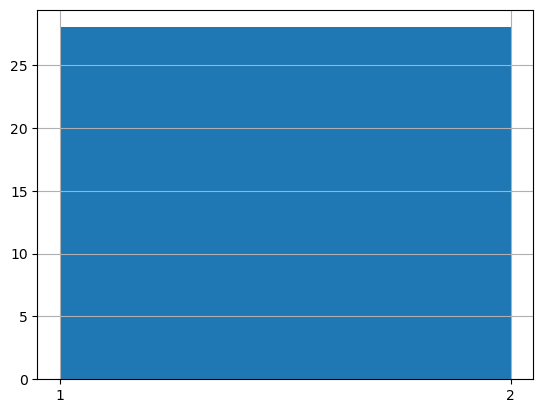

In [15]:
Eventslist[0]['n_fingers'].hist(bins=2)

In [23]:
# analysis of missing frames in qualysis data
n_sequences = np.arange(1,11)

for n_sequence in n_sequences:

    file_destin = (data_dir / 'Qualisys' / ('sequence' + str(n_sequence) + '_6D.tsv')).resolve()

    Data_Qualisys = pd.read_csv(file_destin, sep='\t' , decimal=',', header = line_number, usecols = range(0,18)).astype(Qualisys_dtypes)

    Data_Qualisys.rename(columns={'Frame': 'frame_idx', 'Right_Hand X': 'Handpoint_X', 'Y': 'Handpoint_Y', 'Z': 'Handpoint_Z', 'Time': 'timestamp'}, inplace=True)
    Data_Qualisys.loc[:, 'frame_idx'] = Data_Qualisys.loc[:, 'frame_idx'] - 1

    coverage = sum((Data_Qualisys.loc[:, 'Handpoint_X'] != 0.0) & (Data_Qualisys.loc[:, 'Handpoint_Y'] != 0.0) & (Data_Qualisys.loc[:, 'Handpoint_Z'] != 0.0)) / len(Data_Qualisys.loc[:, 'Handpoint_X'])
    print(f'Hand pose coverage in sequence {n_sequence}: {coverage*100 :.1f}%')





Hand pose coverage in sequence 1: 99.5%
Hand pose coverage in sequence 2: 99.4%
Hand pose coverage in sequence 3: 99.8%
Hand pose coverage in sequence 4: 99.9%
Hand pose coverage in sequence 5: 99.5%
Hand pose coverage in sequence 6: 99.7%
Hand pose coverage in sequence 7: 99.5%
Hand pose coverage in sequence 8: 100.0%
Hand pose coverage in sequence 9: 99.9%
Hand pose coverage in sequence 10: 99.7%


In [94]:
trans = np.array([[1,0,0],[0,0,1],[0,-1,0]])
trans

array([[ 1,  0,  0],
       [ 0,  0,  1],
       [ 0, -1,  0]])

In [91]:
v_test = np.array([[0],[1],[0]])
v_test

array([[0],
       [1],
       [0]])

In [92]:
trans @ v_test

array([[0],
       [0],
       [1]])

In [95]:
# apply and check rotation for one sequnece

n_sequence = 1

file_destin = (data_dir / 'Qualisys' / ('sequence' + str(n_sequence) + '_6D.tsv')).resolve()
Data_Qualisys = pd.read_csv(file_destin, sep='\t' , decimal=',', header = line_number, usecols = range(0,18)).astype(Qualisys_dtypes)

Data_Qualisys.rename(columns={'Frame': 'frame_idx', 'Right_Hand X': 'Handpoint_X', 'Y': 'Handpoint_Y', 'Z': 'Handpoint_Z', 'Time': 'timestamp'}, inplace=True)
Data_Qualisys.loc[:, 'frame_idx'] = Data_Qualisys.loc[:, 'frame_idx'] - 1

# display coordinate system of the hand
row = Data_Qualisys.iloc[0,:]
rot_mat = row[['Rot[0]', 'Rot[1]', 'Rot[2]', 'Rot[3]', 'Rot[4]', 'Rot[5]', 'Rot[6]', 'Rot[7]', 'Rot[8]']].values.reshape(3, 3).transpose()

fig = go.Figure()

rot_mat = trans @ rot_mat
# Add the 3D line
fig.add_trace(go.Scatter3d(
    x=[0, rot_mat[0, 0]],
    y=[0, rot_mat[1, 0]],
    z=[0, rot_mat[2, 0]],
    mode='lines',
    line=dict(color='red', width=5),
    name = 'X'
))
fig.add_trace(go.Scatter3d(
    y=[0, rot_mat[1, 1]],
    z=[0, rot_mat[2, 1]],
    x=[0, rot_mat[0, 1]],
    mode='lines',
    line=dict(color='green', width=5),
    name='Y'
))
fig.add_trace(go.Scatter3d(
    x=[0, rot_mat[0, 2]],
    y=[0, rot_mat[1, 2]],
    z=[0, rot_mat[2, 2]],
    mode='lines',
    line=dict(color='blue', width=5),
    name='Z'
))

# Set plot title and labels
fig.update_layout(
    title='3D Line Plot',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        camera=dict(
            eye=dict(x=0, y=1.25, z=1.25),  # Adjust the camera position
            up = dict(x=0, y=1, z=0)
        )
    )
)

In [72]:
np.reshape(np.arange(0,9), (3,3)).transpose()

array([[0, 3, 6],
       [1, 4, 7],
       [2, 5, 8]])

In [10]:
# Dataprocessing Qualisys Data
n_sequences = np.arange(1,11)
Qualisys_dtypes = {'Frame': 'int32', 'Time': 'float32', 'Right_Hand X':'float32', 'Y':'float32', 'Z':'float32', 'Roll':'float32', 'Pitch':'float32', 'Yaw':'float32',
    'Residual':'float32', 'Rot[0]':'float32', 'Rot[1]':'float32', 'Rot[2]':'float32', 'Rot[3]':'float32', 'Rot[4]':'float32', 'Rot[5]':'float32',
    'Rot[6]':'float32', 'Rot[7]':'float32', 'Rot[8]':'float32'}

quatnames = ['Handpoint_Quaternion_v1', 'Handpoint_Quaternion_v2', 'Handpoint_Quaternion_v3', 'Handpoint_Quaternion_s']
pt_names = ['Handpoint_X', 'Handpoint_Y', 'Handpoint_Z']

trans = np.array([[1,0,0],[0,0,1],[0,-1,0]])

Events_dtypes = {'name': 'str', 'frame_idx': 'int32', 'timestamp': 'float32', 'n_gesture': 'int8', 'n_fingers': 'int8', 'start_end': 'str'}

Datasetslist = []
for n_sequence in n_sequences:

    file_destin = (data_dir / 'Qualisys' / ('sequence' + str(n_sequence) + '_6D.tsv')).resolve()

    line_number = 0
    eventlines = []
    with open(file_destin, 'r') as file:
        for line in file:
            if line.startswith("EVENT"):
                eventlines.append(line_number)
            if line.startswith("Frame"):
                break
            line_number += 1


    print('Number of annotated gestures: ', len(eventlines))

    Events = pd.read_csv(file_destin, sep='\t' , decimal=',', skiprows=min(eventlines), nrows=max(eventlines)-min(eventlines)+1, usecols = [1,2,3], names = ['name', 'frame_idx', 'timestamp'])
    Events[['n_gesture', 'n_fingers', 'start_end']] = Events['name'].str.extract(r'g(\d+)f(\d+)([a-z])')
    Events = Events.astype(Events_dtypes)
    
    # Data_Qualisys = pd.read_csv(file_destin, sep='\t' , decimal=',', header = line_number, usecols = range(0,18)).astype(Qualisys_dtypes)
    Data_Qualisys = pd.read_csv(file_destin, sep='\t' , decimal=',', header = line_number, usecols = range(0,18)).astype(Qualisys_dtypes)

    Data_Qualisys.rename(columns={'Frame': 'frame_idx', 'Right_Hand X': 'Handpoint_X', 'Y': 'Handpoint_Y', 'Z': 'Handpoint_Z', 'Time': 'timestamp'}, inplace=True)
    Data_Qualisys.loc[:, 'frame_idx'] = Data_Qualisys.loc[:, 'frame_idx'] - 1
    Events.loc[:, 'frame_idx'] = Events.loc[:, 'frame_idx'] - 1

    if n_sequence == 2:
        Data_Qualisys = Data_Qualisys.drop(index = [9615, 9616, 9617, 9618, 9619]) # unfortunate recording difference in Manus Data and Qualysis data with this recording

    # transform coordinate system
    Data_Qualisys[pt_names] = Data_Qualisys.apply(lambda row: coordinatesystem_rotation(row, trans_mat=trans), axis=1)

    
    InterpolationIndexes = (Data_Qualisys['Handpoint_X'] == 0) & (Data_Qualisys['Handpoint_Y'] == 0) & (Data_Qualisys['Handpoint_Z'] == 0)
    Data_Qualisys.loc[InterpolationIndexes, pt_names] = np.nan
    Data_Qualisys.loc[:, pt_names] = Data_Qualisys.loc[:, pt_names].interpolate(method = 'linear')

    # Apply the conversion to each row and create a new DataFrame with the quaternion components
    Data_Qualisys[quatnames] = Data_Qualisys.apply(lambda row: matrix_to_quaternion(row, trans_mat = trans), axis=1) # important not to use loc, loc is not working in ths case
    Data_Qualisys.drop(columns=['Roll', 'Pitch', 'Yaw', 'Residual', 'Rot[0]', 'Rot[1]', 'Rot[2]', 'Rot[3]', 'Rot[4]', 'Rot[5]', 'Rot[6]', 'Rot[7]', 'Rot[8]'], inplace=True)

    # interpolate quaternions
    slerp = Slerp(Data_Qualisys.loc[~InterpolationIndexes, 'timestamp'], 
                  Rotation.from_quat(Data_Qualisys.loc[~InterpolationIndexes, quatnames].values))
    Data_Qualisys.loc[:, quatnames] = slerp(Data_Qualisys.loc[:, 'timestamp']).as_quat().astype('float32')
    
    # Manus Data
    Data_Manus = pd.read_csv((data_dir / 'Manus' / ('sequence' + str(n_sequence) + '_mado_R.csv')).resolve(), sep='\t' , decimal=',')
    Data_Manus.rename(columns={'Frame': 'frame_idx', 'Thumb_PIP_Flex': 'Thumb_MCP_Flex', 'Thumb_DIP_Flex': 'Thumb_IP_Flex'}, inplace=True)
    # Data_Manus['Elapsed_Time_In_Seconds'] = Data_Manus['Elapsed_Time_In_Milliseconds']/1000
    Data = Data_Qualisys.join(Data_Manus.set_index('frame_idx').loc[:, 'Thumb_CMC_Spread':].astype('float32'), on='frame_idx')
    #Data = Data_Qualisys.join(Data_Manus.set_index('Frame').loc[:, 'Thumb_CMC_Spread':'Pinky_DIP_Flex'], on='Frame')

    # Label Sequence
    for eventidx, event in Events.iterrows():
        Data.loc[0, 'label'] = 0
        Data.loc[0, 'n_fingers'] = 0
        # Data.loc[event['frame_idx'], 'eventtimestamp'] = event['timestamp']
        if event['start_end'] == 's':
            Data.loc[event['frame_idx'], 'label'] = event['n_gesture']
            Data.loc[event['frame_idx'], 'n_fingers'] = event['n_fingers']
        elif event['start_end'] == 'e':
            Data.loc[event['frame_idx'] + 1, 'label'] = 0
            Data.loc[event['frame_idx'] + 1, 'n_fingers'] = 0
        else:
            raise ValueError('Event {eventidx} in sequence {n_sequence} not correctly labeled')
    Data.loc[:, ('label', 'n_fingers')] = Data.loc[:, ('label', 'n_fingers')].ffill()
    Data.loc[:, 'n_sequence'] = n_sequence


    Datasetslist.append(Data)

Datasets_df = pd.concat(Datasetslist)
Datasets_df[['label', 'n_fingers', 'n_sequence']] = Datasets_df.loc[:, ['label', 'n_fingers', 'n_sequence']].astype('uint8')

Datasets_df.to_pickle((data_dir / 'Dataset.pkl').resolve())

info_dtypes = { 'n_subject': 'uint8', 'n_gesture': 'uint8', 'n_finger': 'uint8', 'n_essai': 'uint8', 'window_idx': 'uint16',
                            'window_idx_overall': 'uint16', 'frame_idx': 'uint16', 'timestamp': 'float32',  'label': 'int8'}

            

    
    

Number of annotated gestures:  56
Number of annotated gestures:  56
Number of annotated gestures:  56
Number of annotated gestures:  56
Number of annotated gestures:  56
Number of annotated gestures:  56
Number of annotated gestures:  56
Number of annotated gestures:  56
Number of annotated gestures:  56
Number of annotated gestures:  56


In [108]:
Datasets_df.dtypes

frame_idx                    int32
timestamp                  float32
Handpoint_X                float32
Handpoint_Y                float32
Handpoint_Z                float32
Handpoint_Quaternion_v1    float32
Handpoint_Quaternion_v2    float32
Handpoint_Quaternion_v3    float32
Handpoint_Quaternion_s     float32
Thumb_CMC_Spread           float32
Thumb_CMC_Flex             float32
Thumb_MCP_Flex             float32
Thumb_IP_Flex              float32
Index_MCP_Spread           float32
Index_MCP_Flex             float32
Index_PIP_Flex             float32
Index_DIP_Flex             float32
Middle_MCP_Spread          float32
Middle_MCP_Flex            float32
Middle_PIP_Flex            float32
Middle_DIP_Flex            float32
Ring_MCP_Spread            float32
Ring_MCP_Flex              float32
Ring_PIP_Flex              float32
Ring_DIP_Flex              float32
Pinky_MCP_Spread           float32
Pinky_MCP_Flex             float32
Pinky_PIP_Flex             float32
Pinky_DIP_Flex      

In [ ]:
# Dataprocessing Manus Data

Data_Manus = pd.read_csv((data_dir / 'Manus' / 'sequence1_mado_R.csv').resolve(), sep='\t' , decimal=',')
Data_Manus['Elapsed_Time_In_Seconds'] = Data_Manus['Elapsed_Time_In_Milliseconds']/1000

In [17]:
Data_Qualisys.iloc[-1]


Frame                           10319
Time                        171.96667
Right_Hand X                420.79040
Y                          -779.17439
Z                           264.16210
Roll                        -81.05405
Pitch                        32.54673
Yaw                        -177.80429
Residual                      0.10218
Rot[0]                       -0.84233
Rot[1]                        0.52510
Rot[2]                        0.12144
Rot[3]                        0.03230
Rot[4]                       -0.17575
Rot[5]                        0.98391
Rot[6]                        0.53799
Rot[7]                        0.83270
Rot[8]                        0.13108
Handpoint_Quaternion_v1      0.224907
Handpoint_Quaternion_v2      0.619579
Handpoint_Quaternion_v3         0.733
Handpoint_Quaternion_s      -0.168076
Name: 10318, dtype: object